In [55]:
import numpy as np
import pdb
import os, sys
import pickle
import torch
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms

from torch.autograd import Variable
from scipy.spatial.distance import cdist
import scipy
from tqdm import tqdm
from collections import OrderedDict


p = os.path.abspath('../')
sys.path.insert(1, p)

from models.vgg_cif10 import VGG
from models.wideresidual import WideResNet, WideBasic
from models.orig_resnet import wide_resnet50_2

import argparse
import sklearn
import sklearn.covariance
import matplotlib.pyplot as plt

In [2]:
# images_path       = "../data/attacks/run_1/cif10/wrn_28_10_10/fgsm/images"
# images_advs_path  = "../data/attacks/run_1/cif10/wrn_28_10_10/fgsm/images_adv"

In [3]:
# images =      torch.load(images_path)[:1500]
# images_advs = torch.load(images_advs_path)[:1500]

In [4]:
def create_new_state_dict(checkpoint, keyword='net'):

    new_state_dict = OrderedDict()
    for k, v in checkpoint[keyword].items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v

    return new_state_dict

In [5]:
depth = 28
widen_factor = 10

model = WideResNet(num_classes=10, block=WideBasic, depth=depth, widen_factor=widen_factor, preprocessing={})

ckpt = torch.load("../submodules/pytorch-CelebAHQ/checkpoint/wideresnet_2810/wide_resnet_ckpt.pth")
new_state_dict = create_new_state_dict(ckpt)
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model = model.eval()

In [7]:
for i, m in enumerate(filter(lambda m: type(m) == torch.nn.Conv2d and m.kernel_size == (3, 3), model.modules())):
    
    w0 = m.weight.detach().cpu().numpy().copy()
    w = (w0.reshape(-1, 9))

    t = np.abs(w).max() / 100    
    cache = np.ones_like(w)
    cache[np.abs(w) < t] = 0
    dead_mask = (cache.sum(axis=1) == 0)
    
    

    with np.printoptions(edgeitems=1000):
        dead_filter = np.where(dead_mask == True)[0]
        # print("sparsity: ", dead_filter)

    usv = np.linalg.svd(w - w.mean(axis=0), full_matrices=False, compute_uv=True)
    u = usv[0]
    s = usv[1]
    v = s**2 / (w.shape[0]-1)

    e = scipy.stats.entropy(v, base=10)
    
    def H_T(n):
        L, x0, k, b = (1.2618047,2.30436435,0.88767525,-0.31050834)  # min distr.
        return L / (1 + np.exp(-k * (np.log2(n) - x0))) + b
    
    dead = (e >= H_T(w.shape[0])) | (e < 0.5)
    # print("dead_mask: ", )

    print("i: ", i, ",dead: ", dead, ", e: ", e, ", H_T: ", H_T(w.shape[0]))

i:  0 ,dead:  False , e:  0.7074111728056349 , H_T:  0.8862397725366638
i:  1 ,dead:  False , e:  0.8896211059801834 , H_T:  0.9508751836794926
i:  2 ,dead:  False , e:  0.8474095304730729 , H_T:  0.9512742821563731
i:  3 ,dead:  False , e:  0.7800455949864453 , H_T:  0.9512742821563731
i:  4 ,dead:  False , e:  0.8082557090880014 , H_T:  0.9512742821563731
i:  5 ,dead:  False , e:  0.9171634656429116 , H_T:  0.9512742821563731
i:  6 ,dead:  False , e:  0.798194713324258 , H_T:  0.9512742821563731
i:  7 ,dead:  False , e:  0.8290475259317821 , H_T:  0.9512742821563731
i:  8 ,dead:  False , e:  0.7532617977394178 , H_T:  0.9512742821563731
i:  9 ,dead:  False , e:  0.7066748205507543 , H_T:  0.9512872724113322
i:  10 ,dead:  False , e:  0.8443278374196612 , H_T:  0.9512926194278255
i:  11 ,dead:  False , e:  0.7999492660638517 , H_T:  0.9512926194278255
i:  12 ,dead:  False , e:  0.7969917702934137 , H_T:  0.9512926194278255
i:  13 ,dead:  False , e:  0.7985889366978531 , H_T:  0.951292

In [81]:
for i, m in enumerate(filter(lambda m: type(m) == torch.nn.Conv2d and m.kernel_size == (3, 3), model.modules())):
    w0 = m.weight.detach().cpu().numpy().copy()
    b0 = m.bias.detach().cpu().numpy().copy()
    w = w0.copy()
    
    if i == 23: 
        t = np.abs(w).max() / 100    
        cache = np.ones_like(w)
        cache[np.abs(w) < t] = 0
        dead_mask = (cache.reshape(w.shape[:2]+(9,)).sum(axis=2) == 0) # 640x640x9 = 9
        dead_filter_tmp = np.sum(dead_mask, axis=0)
        dead_filter = np.where(dead_filter_tmp > 300)[0]
    
    # dead_filter = np.where(dead_mask == True)
    # print(i, "\t",  w0.shape, "\t",cache.shape , '\t', dead_filter.shape)
    print(i, "\t",  w0.shape, "\t", b0.shape)

print("dead_mask", dead_mask.shape)

IndentationError: expected an indented block (2321390939.py, line 7)

In [80]:
torch.save(dead_filter_tmp, './../defenses/sparsity/dead_filter_tmp.pkl'  , pickle_protocol=4)

In [49]:
dead_mask.shape

(640, 640)

In [52]:
dead_filter_tmp

array([279, 281, 280, 273, 257, 255, 267, 281, 279, 355, 288, 281, 340,
       259, 294, 259, 273, 314, 255, 254, 301, 268, 311, 329, 267, 281,
       314, 265, 273, 285, 311, 328, 312, 284, 290, 270, 314, 338, 278,
       296, 264, 270, 249, 276, 256, 256, 286, 297, 270, 261, 296, 296,
       290, 271, 268, 282, 324, 280, 281, 292, 294, 281, 318, 333, 263,
       318, 256, 300, 260, 290, 287, 262, 286, 267, 305, 285, 315, 264,
       311, 279, 278, 270, 254, 269, 262, 269, 241, 306, 269, 231, 288,
       284, 307, 299, 286, 271, 255, 276, 285, 318, 323, 327, 305, 278,
       280, 254, 275, 296, 356, 281, 238, 246, 337, 330, 271, 311, 247,
       286, 297, 257, 259, 268, 305, 298, 288, 293, 340, 299, 309, 301,
       270, 263, 288, 319, 278, 295, 271, 303, 302, 320, 270, 318, 275,
       245, 261, 274, 290, 271, 369, 342, 261, 259, 288, 309, 243, 368,
       261, 349, 324, 313, 306, 275, 266, 277, 300, 302, 268, 315, 294,
       284, 255, 262, 330, 266, 276, 287, 289, 282, 286, 325, 26

In [66]:
np.where(dead_filter_tmp > 290)[0]

array([  9,  12,  14,  17,  20,  22,  23,  26,  30,  31,  32,  36,  37,
        39,  47,  50,  51,  56,  59,  60,  62,  63,  65,  67,  74,  76,
        78,  87,  92,  93,  99, 100, 101, 102, 107, 108, 112, 113, 115,
       118, 122, 123, 125, 126, 127, 128, 129, 133, 135, 137, 138, 139,
       141, 148, 149, 153, 155, 157, 158, 159, 160, 164, 165, 167, 168,
       172, 179, 181, 183, 184, 186, 187, 189, 191, 193, 195, 197, 204,
       208, 210, 211, 214, 215, 220, 224, 232, 236, 238, 243, 245, 248,
       249, 250, 251, 257, 262, 263, 265, 266, 268, 270, 271, 274, 275,
       277, 280, 294, 302, 303, 304, 305, 306, 307, 309, 310, 312, 314,
       316, 319, 322, 323, 325, 327, 328, 329, 331, 334, 335, 337, 345,
       347, 350, 351, 352, 353, 356, 360, 368, 370, 374, 376, 379, 381,
       383, 384, 389, 392, 405, 406, 410, 411, 414, 415, 419, 427, 428,
       430, 431, 432, 435, 443, 446, 447, 449, 451, 458, 461, 464, 472,
       473, 474, 475, 477, 478, 482, 484, 486, 487, 488, 491, 50

Text(0, 0.5, 'Number filters')

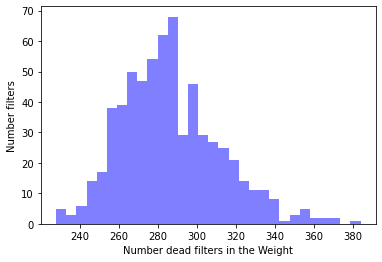

In [75]:
plt.figure()


plt.hist(dead_filter_tmp, 30, density=False, histtype='bar', facecolor='b',  alpha=0.5)
plt.xlabel("Number dead filters in the Weight")
plt.ylabel("Number filters")

In [77]:
np.sort(dead_filter_tmp)


array([228, 229, 231, 232, 232, 235, 237, 238, 240, 241, 241, 241, 243,
       243, 244, 244, 244, 244, 244, 245, 245, 246, 246, 246, 247, 247,
       248, 248, 249, 249, 250, 251, 252, 252, 252, 252, 252, 252, 252,
       252, 253, 253, 253, 253, 253, 254, 254, 254, 254, 254, 255, 255,
       255, 255, 255, 256, 256, 256, 256, 256, 256, 257, 257, 257, 257,
       257, 258, 258, 258, 258, 258, 258, 259, 259, 259, 259, 259, 259,
       259, 259, 259, 259, 259, 260, 260, 261, 261, 261, 261, 261, 261,
       261, 261, 261, 261, 262, 262, 262, 262, 262, 262, 262, 262, 263,
       263, 263, 263, 263, 263, 263, 263, 263, 264, 264, 264, 264, 264,
       264, 264, 264, 264, 264, 265, 265, 265, 265, 265, 265, 265, 266,
       266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 267, 267, 267,
       267, 267, 267, 267, 267, 268, 268, 268, 268, 268, 268, 268, 268,
       268, 268, 268, 268, 268, 269, 269, 269, 269, 269, 269, 269, 269,
       269, 269, 269, 270, 270, 270, 270, 270, 270, 270, 270, 27

In [79]:
np.mean(dead_filter_tmp)

286.496875

In [71]:
np.quantile(dead_filter_tmp, 0.1)

257.0

In [9]:
alive_filter_list = []
dead_filter_list = []

for i, m in enumerate(filter(lambda m: type(m) == torch.nn.Conv2d and m.kernel_size == (3, 3), model.modules())):
    
    w0 = (m.weight.detach().cpu().numpy().copy())
    w = (m.weight.detach().cpu().numpy().reshape(-1, 9).copy())

    t = np.abs(w).max() / 100    
    cache = np.ones_like(w)
    cache[np.abs(w) < t] = 0
    dead_mask  = (cache.sum(axis=1) == 0)
    alive_mask = (cache.sum(axis=1) != 0)

    dead_filter = np.where(dead_mask == True)[0]
    alive_filter = np.where(alive_mask == True)[0]
    
    dead_filter_list.append( (w0.shape, dead_filter) )
    alive_filter_list.append( (w0.shape, alive_filter) )
    print("w.shape: ", w0.shape, "\t dead_filter: ", dead_filter.shape)

w.shape:  (16, 3, 3, 3) 	 dead_filter:  (0,)
w.shape:  (160, 16, 3, 3) 	 dead_filter:  (430,)
w.shape:  (160, 160, 3, 3) 	 dead_filter:  (3359,)
w.shape:  (160, 160, 3, 3) 	 dead_filter:  (301,)
w.shape:  (160, 160, 3, 3) 	 dead_filter:  (91,)
w.shape:  (160, 160, 3, 3) 	 dead_filter:  (1214,)
w.shape:  (160, 160, 3, 3) 	 dead_filter:  (4,)
w.shape:  (160, 160, 3, 3) 	 dead_filter:  (943,)
w.shape:  (160, 160, 3, 3) 	 dead_filter:  (0,)
w.shape:  (320, 160, 3, 3) 	 dead_filter:  (114,)
w.shape:  (320, 320, 3, 3) 	 dead_filter:  (22,)
w.shape:  (320, 320, 3, 3) 	 dead_filter:  (364,)
w.shape:  (320, 320, 3, 3) 	 dead_filter:  (0,)
w.shape:  (320, 320, 3, 3) 	 dead_filter:  (833,)
w.shape:  (320, 320, 3, 3) 	 dead_filter:  (0,)
w.shape:  (320, 320, 3, 3) 	 dead_filter:  (1197,)
w.shape:  (320, 320, 3, 3) 	 dead_filter:  (0,)
w.shape:  (640, 320, 3, 3) 	 dead_filter:  (884,)
w.shape:  (640, 640, 3, 3) 	 dead_filter:  (20,)
w.shape:  (640, 640, 3, 3) 	 dead_filter:  (14068,)
w.shape:  (640

In [10]:
len(alive_filter_list)

25

In [11]:
torch.save(dead_filter_list, './../defenses/sparsity/wrn2810_dead.pkl'  , pickle_protocol=4)

In [12]:
torch.save(alive_filter_list, './../defenses/sparsity/wrn2810.pkl'  , pickle_protocol=4)

In [13]:
sel_filter = torch.load('./../defenses/sparsity/wrn2810.pkl')

In [14]:
sel_filter[0][1].shape

(48,)

In [15]:
dead_filter

array([   137,    148,    155, ..., 409385, 409390, 409497])

In [16]:
w.flatten().shape

(3686400,)

In [17]:
w[dead_filter].shape

(183358, 9)

In [18]:
w[alive_filter].shape

(226242, 9)

In [19]:
w.shape

(409600, 9)

In [20]:
cache.shape

(409600, 9)

In [21]:
arr = np.arange(18).reshape((2,3,3))
arr

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]]])

In [22]:
tmp = arr.reshape(-1,9)

In [23]:
tmp.shape

(2, 9)

In [24]:
tmp.flatten()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [30]:
print(model)

WideResNet(
  (init_conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Sequential(
    (0): WideBasic(
      (residual): Sequential(
        (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Dropout(p=0.5, inplace=False)
        (6): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (shortcut): Sequential(
        (0): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): WideBasic(
      (residual): Sequential(
        (0): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       